# Import packages for this script

In [36]:
# import modules
# for outlier detection, using IQR
import _merge_modules as mo

# import packages
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from pathlib import Path
from pathlib import PureWindowsPath

# Define Home Path
- here all your data is stored
- all inputs as .csv files
    - input
        - data
        - merge-sheet
    - output
        - core

In [40]:
# define home-path
HOME_PATH = Path(PureWindowsPath(r'C:\Users\marce\Documents\my_world\phd\data_science\merge_data\Data\Hallstatt\mscl-round'))

input_path = HOME_PATH / 'input'
data_path = input_path / 'data'

# name of merge_sheet
merge_sheet_path = input_path / 'merge_sheet_test.csv'

output_path = HOME_PATH / 'output'

# Import data_set
- clean data if needed (e.g. MS shifts or density shifts)

In [41]:
files_filtered = list(data_path.rglob('*.csv'))

In [42]:
# import MSCL .csv files to dataframe within dictionary
all_dataframes = {}
df_core_correcting = {}
df_core_original = {}

for file_path in files_filtered:
    # Get file name without .csv at end
    file_name = file_path.stem
    # read csv into a dataframe and add it to dict with file_name as it key
    all_dataframes[file_name] = pd.read_csv(file_path, header=0)
    
all_names = list(all_dataframes.keys())
correcting_names = list(df_core_correcting.keys())

# Import merge_sheet
- composite profile logic table

In [56]:
# import .csv file as dataframe
merge_table_all = pd.read_csv(merge_sheet_path, header=0, sep=";")

# choose needed parameters
merge_para = ['splice_num','Name','core_TOP','core_BOTTOM','Vertical offset','Depth_CSF-A_(m)_Top']

# needed columns
merge_table = merge_table_all.loc[:,merge_para]
# merge_table

# Splice
- cut Data to composite profile length

In [57]:
# cut dic core-tables to splice-table
all_splice = {}

# set choosen parameters
phy_prop = ["CT", "PWAmp", "PWVel", "Den1", "MS1", "Imp", "FP"]

for i in all_names:
    single_dataframe = all_dataframes[i]
    
    # convert to numbers
    for j in phy_prop:
        single_dataframe[j] = pd.to_numeric(single_dataframe[j], downcast="float")
    
    if merge_table['Name'].eq(i).any():
        # divide by 10, to convert mm of merge sheet to cm as MSCL data is measured in cm per core
        cm = 10
        
        top_splice = float(merge_table.loc[merge_table['Name']==i]['core_TOP'])/cm
        bottom_splice = float(merge_table.loc[merge_table['Name']==i]['core_BOTTOM'])/cm
        depth = single_dataframe.loc[:,'SECT DEPTH']
        
        # cut data to splice intervals
        TOP_absolute_val_array = np.abs(depth - top_splice)
        TOP_smallest_difference_index = TOP_absolute_val_array.argmin()
        TOP_closest_element = depth[TOP_smallest_difference_index]    
        
        BOT_absolute_val_array = np.abs(depth - bottom_splice)
        BOT_smallest_difference_index = BOT_absolute_val_array.argmin()
        BOT_closest_element = depth[BOT_smallest_difference_index]
        
        all_splice[i] = single_dataframe.loc[TOP_smallest_difference_index:BOT_smallest_difference_index,:]

# adjust index for depth scale

In [58]:
#convert meter to cm
meter = 100

# transition between core sections
core_hline_li = []

for i in all_splice:
    single_dataframe = all_splice[i]    
    
    vertical_offset = float(merge_table.loc[merge_table['Name']==i]['Vertical offset'] * meter)
    core_depth = round(float((merge_table.loc[merge_table['Name']==i]['Depth_CSF-A_(m)_Top']) * meter) - float((merge_table.loc[merge_table['Name']==i]['core_TOP']) / cm),0)
    
    if merge_table['Name'].eq(i).any():
        sect_depth = single_dataframe.loc[:,'SECT DEPTH']
        composite_depth = map(lambda x:round((x+vertical_offset+core_depth),2), sect_depth)
        single_dataframe = single_dataframe.set_index(composite_depth)
        single_dataframe['splice_num'] = float(merge_table.loc[merge_table['Name'] == i]['splice_num'])
        all_splice[i] = single_dataframe
        core_hline_li.append(round(float(single_dataframe.index[-1]),2) / meter)

# Remove outliers

In [59]:
# multiple cores
dic_splice_out = {}

for i in all_splice:
    core_x = all_splice[i]
    core_x = core_x
    dropped = mo.drop_outliers_IQR(core_x['Den1'])
    core_dropped = core_x.loc[core_x['Den1'].isin(dropped)]
    dic_splice_out[i] = core_dropped
# dic_splice_out

# Merge all core sections of splice

In [60]:
# add to one dataframe for plotting and smooting
all_cores = pd.DataFrame()

for i in dic_splice_out:
    x = dic_splice_out[i]
    
    all_cores = all_cores.append(x)
    
cores_sort = all_cores.sort_values(['splice_num','SECT DEPTH'])

# covert back to meter scale
mscl_index = np.divide(cores_sort.index.tolist(),100)
cores_sort = cores_sort.set_index(mscl_index)

# for unfilterd raw data
all_cores_raw = pd.DataFrame()

for i in all_splice:
    x = all_splice[i]
    
    all_cores_raw = all_cores_raw.append(x)
    
cores_sort_raw = all_cores_raw.sort_values(['splice_num','SECT DEPTH'])

mscl_index_raw = np.divide(cores_sort_raw.index.tolist(),100)
cores_sort_raw = cores_sort_raw.set_index(mscl_index_raw)

# smooth data

In [61]:
# for Den1 and MS1
phy_prop = ["Den1", "MS1"]

c_prep = cores_sort.loc[:, phy_prop]

# filter_length_RA
filter_length_GF = 15

# standard = 1
stdd = 2

c_prep_smoothed = cores_sort.loc[:, phy_prop]

for i in range(c_prep.shape[1]):
    c_prep_smoothed = c_prep_smoothed.rolling(window=filter_length_GF, win_type="gaussian", center=True).mean(std=stdd)

# plot

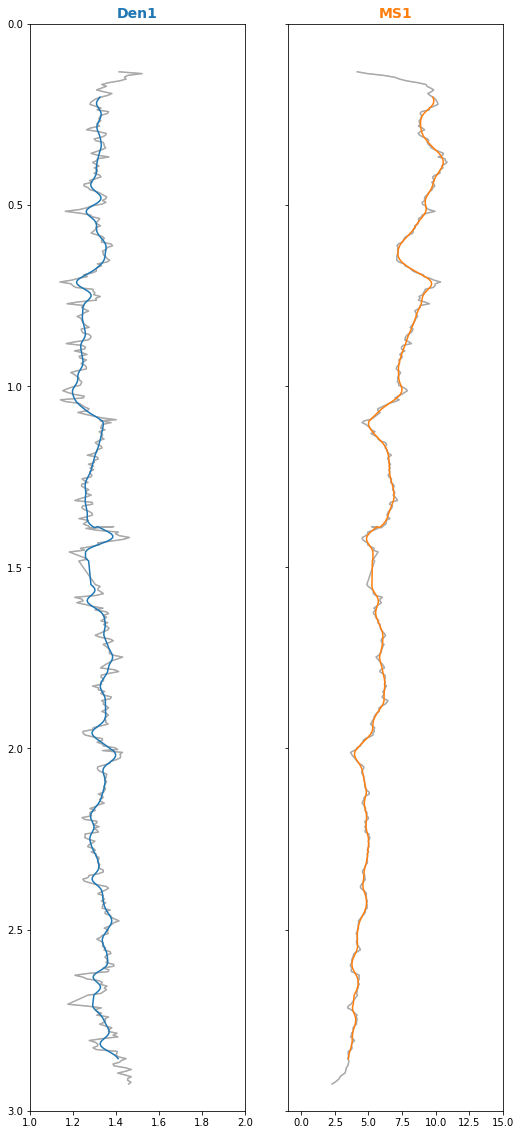

In [62]:
start_coordinate = 0
end_coordinate = 3

width_pl = ([1] * c_prep.shape[1])

fig, ax = plt.subplots(nrows=1, ncols=c_prep.shape[1], figsize=(7.5,20),
                        gridspec_kw=dict(height_ratios=[8], width_ratios=width_pl), sharey="all")

# raw data plot first
c_prep_raw = cores_sort_raw.loc[:, phy_prop]

for (i, a), (l, d) in zip(enumerate(ax[:]), c_prep_raw.iteritems()):
    a.plot(d.values, d.index, label=l, color="lightgray".format(i), linewidth=1)

# outliers dropped
for (i, a), (l, d) in zip(enumerate(ax[:]), c_prep.iteritems()):
    a.plot(d.values, d.index, label=l, color="darkgray".format(i))
    a.set_title(l, fontdict={"color": "C{}".format(i), "fontweight": "bold", "fontsize":14})
    a.set_xlim(1, 2) if l == "Den1" else a.set_xlim(-1, 15)
    a.set_ylim(end_coordinate,start_coordinate)

# smoothed data
for (i, a), (l, d) in zip(enumerate(ax[:]), c_prep_smoothed.iteritems()):
    a.plot(d.values, d.index, label=l, color="C{}".format(i))

bbox = dict(boxstyle ="round", fc ="0.8", )

# Name of output file + file type
c_name = 'Name-composite-core.svg'
output = output_path / c_name

plt.subplots_adjust(left=None, bottom=None, right=1, top=None, wspace=0.2, hspace=None)
plt.savefig(c_name, format = 'svg', dpi=150, transparent=True)